In [ ]:
!pip install tensorflow tensorflow-gpu opencv-python matplotlib
!pip install numpy scipy matplotlib pandas sympy nose Shapely

In [1]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import linregress
import cv2

from numpy import ones,vstack
from numpy.linalg import lstsq
import math

from shapely.geometry import LineString

In [ ]:
#Download Model on Lniux (one time activity)
!wget -q -O lite-model_movenet_singlepose_lightning_3.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/lightning/3?lite-format=tflite

In [ ]:
#Download Model on Windows (one time activity)
import requests
url= "https://tfhub.dev/google/lite-model/movenet/singlepose/lightning/3?lite-format=tflite"
r= requests.get(url, allow_redirects=True)
open('lite-model_movenet_singlepose_lightning_3.tflite', 'wb').write(r.content)

# 1. Load Model

In [ ]:
interpreter = tf.lite.Interpreter(model_path='lite-model_movenet_singlepose_lightning_3.tflite')
interpreter.allocate_tensors()

# 2. Relevent functions 

In [2]:
#function to get corners of a square with only the coordinates of the line in middle
def get_quadCorners(x1, y1, x2, y2, factor):
    
#     print("Passing to Fn: " + str(x1) + ", " + str(x2) + ", " + str(y1) + ", " + str(y2))
    line_length = math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
    slope, intercept, r_value, p_value, std_err = linregress([x1,x2],[y1,y2])
    
    a = (x1, y1)
    b = (x2, y2)
    ab = LineString([a, b])
    left = ab.parallel_offset(line_length / int(factor), 'left')
    right = ab.parallel_offset(line_length / int(factor), 'right')
    
    c = left.boundary[1]
    d = right.boundary[0]
    e = left.boundary[0]
    f = right.boundary[1]
    
    points = np.array(
    [
        [c.x, c.y],
        [d.x, d.y],
        [e.x, e.y],
        [f.x, f.y],
    ])
    
#     print(slope,intercept)
    return (points)        

C:\Users\devops\AppData\Local\Temp/ipykernel_5596/1626967186.py:14: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  c = left.boundary[1]
C:\Users\devops\AppData\Local\Temp/ipykernel_5596/1626967186.py:15: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  d = right.boundary[0]
C:\Users\devops\AppData\Local\Temp/ipykernel_5596/1626967186.py:16: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  e = left.boundary[0]
C:\Users\devops\AppData\Local\Temp/ipykernel_5596/1626967186.py:17: ShapelyDeprecationWarning: __getitem__ for multi-part geometries

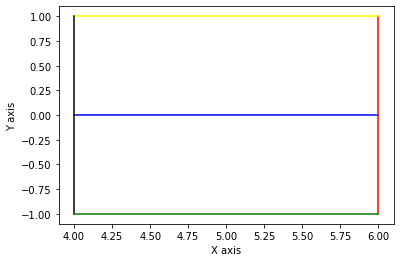

In [3]:
a, b = [[4,0], [6,0]]   # point definition
squareCorners = get_quadCorners(a[0], a[1], b[0], b[1], 2)

plt.plot([a[0],b[0]], [a[1],b[1]], color = 'blue')
plt.plot([squareCorners[0][0], squareCorners[1][0]], [squareCorners[0][1], squareCorners[1][1]], color='red')
plt.plot([squareCorners[0][0], squareCorners[2][0]], [squareCorners[0][1], squareCorners[2][1]], color='yellow')
plt.plot([squareCorners[2][0], squareCorners[3][0]], [squareCorners[2][1], squareCorners[3][1]], color='black')
plt.plot([squareCorners[1][0], squareCorners[3][0]], [squareCorners[1][1], squareCorners[3][1]], color='green')

plt.xlabel('X axis')
plt.ylabel('Y axis')
plt.show()

In [4]:
class all_keypoints_withnames:
  def __init__(self, x, y, confidence, name):
    self.x = x
    self.y = y
    self.confidence = confidence
    self.name = name

In [5]:
def keypoints_modification(frame, keypoints):
    y, x, c = frame.shape
    shaped = np.squeeze(np.multiply(keypoints, [y,x,1]))
    shaped_modified = np.empty(shape=(53, 4), dtype=all_keypoints_withnames)
    
    marker_name = ['nose', 'left eye','right eye', 'left ear', 'right ear', 'left shoulder', 'right shoulder', 'left elbow', 'right elbow', 'left wrist','right wrist', 'left hip', 'right hip', 'left knee', 'right knee', 'left ankle', 'right ankle']  
    marker_count = 0
    leg_factor= 3
    hand_factor= 4
    
    for kp in shaped:
        ky, kx, kp_conf = kp
        
        shaped_modified[marker_count] = [ky, kx, kp_conf, marker_name[marker_count]]  # getting new keypoints array populated with inital points            
        marker_count=marker_count+1

    # Custom points displayed and added in the list for FACE square
    squareCorners = get_quadCorners(shaped_modified[3][1], shaped_modified[3][0], shaped_modified[4][1], shaped_modified[4][0], 2)
    # Adding new keypoints for face square
    shaped_modified[17] = [squareCorners[0][1], squareCorners[0][0], shaped_modified[3][2], "face top right"] 
    shaped_modified[18] = [squareCorners[1][1], squareCorners[1][0], shaped_modified[3][2], "face bottom right"]
    shaped_modified[19] = [squareCorners[2][1], squareCorners[2][0], shaped_modified[3][2], "face top left"]
    shaped_modified[20] = [squareCorners[3][1], squareCorners[3][0], shaped_modified[3][2], "face bottom left"]

    # Custom points displayed and added in the list for left bicep rectangle
    squareCorners = get_quadCorners(shaped_modified[5][1], shaped_modified[5][0], shaped_modified[7][1], shaped_modified[7][0], hand_factor)
    # Adding new keypoints for face square
    shaped_modified[21] = [squareCorners[0][1], squareCorners[0][0], shaped_modified[5][2], "left bicep bottom right"] 
    shaped_modified[22] = [squareCorners[1][1], squareCorners[1][0], shaped_modified[5][2], "left bicep bottom left"]
    shaped_modified[23] = [squareCorners[2][1], squareCorners[2][0], shaped_modified[5][2], "left bicep top right"]
    shaped_modified[24] = [squareCorners[3][1], squareCorners[3][0], shaped_modified[5][2], "left bicep top left"]

    # Custom points displayed and added in the list for left forearm rectangle
    squareCorners = get_quadCorners(shaped_modified[7][1], shaped_modified[7][0], shaped_modified[9][1], shaped_modified[9][0], hand_factor)
    # Adding new keypoints for face square
    shaped_modified[25] = [squareCorners[0][1], squareCorners[0][0], shaped_modified[7][2], "left forearm bottom right"] 
    shaped_modified[26] = [squareCorners[1][1], squareCorners[1][0], shaped_modified[7][2], "left forearm bottom left"]
    shaped_modified[27] = [squareCorners[2][1], squareCorners[2][0], shaped_modified[7][2], "left forearm top right"]
    shaped_modified[28] = [squareCorners[3][1], squareCorners[3][0], shaped_modified[7][2], "left forearm top left"]

    # Custom points displayed and added in the list for right bicep rectangle
    squareCorners = get_quadCorners(shaped_modified[6][1], shaped_modified[6][0], shaped_modified[8][1], shaped_modified[8][0], hand_factor)
    # Adding new keypoints for face square
    shaped_modified[29] = [squareCorners[0][1], squareCorners[0][0], shaped_modified[6][2], "right bicep bottom right"] 
    shaped_modified[30] = [squareCorners[1][1], squareCorners[1][0], shaped_modified[6][2], "right bicep bottom left"]
    shaped_modified[31] = [squareCorners[2][1], squareCorners[2][0], shaped_modified[6][2], "right bicep top right"]
    shaped_modified[32] = [squareCorners[3][1], squareCorners[3][0], shaped_modified[6][2], "right bicep top left"]

    # Custom points displayed and added in the list for right forearm rectangle
    squareCorners = get_quadCorners(shaped_modified[8][1], shaped_modified[8][0], shaped_modified[10][1], shaped_modified[10][0], hand_factor)
    # Adding new keypoints for face square
    shaped_modified[33] = [squareCorners[0][1], squareCorners[0][0], shaped_modified[8][2], "right forearm bottom right"] 
    shaped_modified[34] = [squareCorners[1][1], squareCorners[1][0], shaped_modified[8][2], "right forearm bottom left"]
    shaped_modified[35] = [squareCorners[2][1], squareCorners[2][0], shaped_modified[8][2], "right forearm top right"]
    shaped_modified[36] = [squareCorners[3][1], squareCorners[3][0], shaped_modified[8][2], "right forearm top left"]

    # Custom points displayed and added in the list for left thigh rectangle
    squareCorners = get_quadCorners(shaped_modified[11][1], shaped_modified[11][0], shaped_modified[13][1], shaped_modified[13][0], leg_factor)
    # Adding new keypoints for face square
    shaped_modified[37] = [squareCorners[0][1], squareCorners[0][0], shaped_modified[11][2], "left thigh bottom right"] 
    shaped_modified[38] = [squareCorners[1][1], squareCorners[1][0], shaped_modified[11][2], "left thigh bottom left"]
    shaped_modified[39] = [squareCorners[2][1], squareCorners[2][0], shaped_modified[11][2], "left thigh top right"]
    shaped_modified[40] = [squareCorners[3][1], squareCorners[3][0], shaped_modified[11][2], "left thigh top left"]

    # Custom points displayed and added in the list for left calf rectangle
    squareCorners = get_quadCorners(shaped_modified[13][1], shaped_modified[13][0], shaped_modified[15][1], shaped_modified[15][0], leg_factor)
    # Adding new keypoints for face square
    shaped_modified[41] = [squareCorners[0][1], squareCorners[0][0], shaped_modified[13][2], "left calf bottom right"] 
    shaped_modified[42] = [squareCorners[1][1], squareCorners[1][0], shaped_modified[13][2], "left calf bottom left"]
    shaped_modified[43] = [squareCorners[2][1], squareCorners[2][0], shaped_modified[13][2], "left calf top right"]
    shaped_modified[44] = [squareCorners[3][1], squareCorners[3][0], shaped_modified[13][2], "left calf top left"]

    # Custom points displayed and added in the list for right thigh rectangle
    squareCorners = get_quadCorners(shaped_modified[12][1], shaped_modified[12][0], shaped_modified[14][1], shaped_modified[14][0], leg_factor)
    # Adding new keypoints for face square
    shaped_modified[45] = [squareCorners[0][1], squareCorners[0][0], shaped_modified[12][2], "right thigh bottom right"] 
    shaped_modified[46] = [squareCorners[1][1], squareCorners[1][0], shaped_modified[12][2], "right thigh bottom left"]
    shaped_modified[47] = [squareCorners[2][1], squareCorners[2][0], shaped_modified[12][2], "right thigh top right"]
    shaped_modified[48] = [squareCorners[3][1], squareCorners[3][0], shaped_modified[12][2], "right thigh top left"]

    # Custom points displayed and added in the list for right calf rectangle
    squareCorners = get_quadCorners(shaped_modified[14][1], shaped_modified[14][0], shaped_modified[16][1], shaped_modified[16][0], leg_factor)
    # Adding new keypoints for face square
    shaped_modified[49] = [squareCorners[0][1], squareCorners[0][0], shaped_modified[14][2], "right calf bottom right"] 
    shaped_modified[50] = [squareCorners[1][1], squareCorners[1][0], shaped_modified[14][2], "right calf bottom left"]
    shaped_modified[51] = [squareCorners[2][1], squareCorners[2][0], shaped_modified[14][2], "right calf top right"]
    shaped_modified[52] = [squareCorners[3][1], squareCorners[3][0], shaped_modified[14][2], "right calf top left"]

#     print((shaped_modified))
#     count = 0
#     for sm in shaped_modified:
#         print(str(count) + ": " + str(sm[3]))
#         count = count + 1 
    return shaped_modified

In [6]:
def draw_keypoints(frame, keypoints, confidence_threshold):
    y, x, c = frame.shape
    
    marker_count = 0
    
    for kp in keypoints:
        ky, kx, kp_conf, kp_name = kp
        
        if kp_conf > confidence_threshold:
#             if (not (marker_count in list(range(17)))):
            if(marker_count in [17,18,19,20]):
                cv2.circle(frame, (int(kx), int(ky)), 4, (0,255,0), -1) 
                # put text on markers
                cv2.putText(frame, str(kp_name), (int(kx), int(ky)), cv2.FONT_HERSHEY_PLAIN, 2, (255,255,255),2,cv2.LINE_AA)
#             cv2.putText(frame, str(str(int(kx)) + ',' + str(int(kx))), (int(kx), int(ky)), cv2.FONT_HERSHEY_PLAIN, 2, (255,255,255),2,cv2.LINE_AA)
#             cv2.putText(frame, marker_name[marker_count], (int(kx), int(ky)), cv2.FONT_HERSHEY_PLAIN, 2, (255,255,255),2,cv2.LINE_AA)

        marker_count=marker_count+1

In [11]:
BOX_EDGES = {
    (17, 18): 'm',
    (18, 20): 'c',
    (20, 19): 'm',
    (17, 19): 'c',
    (18, 6): 'm',
    (20, 5): 'c',
    (5, 6): 'm',
    (5, 40): 'm',
    (6, 47): 'c',
    (40, 47): 'c',
    
    (23, 24): 'y',
    (21, 22): 'm',
    (22, 24): 'c',
    (21, 23): 'y',    
    (25, 26): 'm',
    (27, 28): 'm',
    (25, 27): 'c',
    (26, 28): 'c',
    
    (29, 30): 'y',
    (31, 32): 'm',
    (29, 31): 'c',
    (30, 32): 'y',
    (33, 34): 'm',
    (35, 36): 'm',
    (33, 35): 'c',
    (34, 36): 'c',

    (37, 38): 'y',
    (39, 40): 'm',
    (37, 39): 'c',
    (38, 40): 'y',
    (41, 42): 'm',
    (43, 44): 'm',
    (41, 43): 'c',
    (42, 44): 'c',
    
    (45, 46): 'y',
    (47, 48): 'm',
    (45, 47): 'c',
    (46, 48): 'y',
    (49, 50): 'm',
    (51, 52): 'm',
    (49, 51): 'c',
    (50, 52): 'c',
}
        
def draw_connections(frame, keypoints, edges, confidence_threshold):
    y, x, c = frame.shape
    
    for edge, color in edges.items():
        p1, p2 = edge
        y1, x1, c1, n1 = keypoints[p1]
        y2, x2, c2, n2 = keypoints[p2]
        
        if (c1 > confidence_threshold) & (c2 > confidence_threshold):      
            cv2.line(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0,0,255), 2)
            

(512, 512, 3)


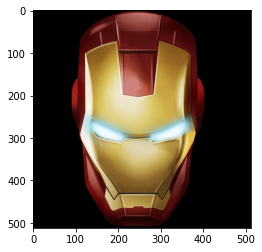

In [13]:
headimg = cv2.imread(r'C:\Users\devops\PoseEstimationProject\head.jpg', cv2.IMREAD_COLOR)
headimg= cv2.cvtColor(headimg, cv2.COLOR_BGR2RGB)
print(headimg.shape)
plt.imshow(headimg)

In [ ]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    
    # Reshape image
    img = frame.copy()
    
    img = tf.image.resize_with_pad(np.expand_dims(img, axis=0), 192, 192)
    input_image = tf.cast(img, dtype=tf.float32)
    
    # Setup input and output 
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    
    # Make predictions 
    interpreter.set_tensor(input_details[0]['index'], np.array(input_image))
    interpreter.invoke()
    keypoints_with_scores = interpreter.get_tensor(output_details[0]['index'])
    
    #Rendering with background image, using black image
    img = np.zeros((512,512,3), np.uint8)
    
    new_keypoints = keypoints_modification(frame, keypoints_with_scores)
    draw_connections(img, new_keypoints, BOX_EDGES, 0.4)
    draw_keypoints(img, new_keypoints, 0.4)
    
    cv2.imshow('MoveNet Lightning', img)
    
    # Rendering with orignal frame  
#     draw_connections(frame, new_keypoints, BOX_EDGES, 0.4)
#     draw_keypoints(frame, new_keypoints, 0.4)    
#     cv2.imshow('MoveNet Lightning', frame)
    
    if cv2.waitKey(10) & 0xFF==ord('q'):
        break
        
cap.release()
cv2.destroyAllWindows()